<a href="https://colab.research.google.com/github/Hriday1001/Braille_Sentence_Recognition/blob/main/BrailleOpenCV_character.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from zipfile import ZipFile
file_name = "/content/archive.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [2]:
import os
from shutil import copyfile

In [3]:
os.makedirs('./images/' , exist_ok = True)
alpha = 'a'
for i in range(0, 26):
	os.makedirs('./images/' + alpha , exist_ok = True)
	alpha = chr(ord(alpha) + 1)

In [4]:
rootdir = '/content/Braille Dataset/Braille Dataset/'
for file in os.walk(rootdir):
  for ind_file in file[2]:
    ind_file_string = ''.join(str(elm) for elm in ind_file)
    path = (rootdir + ind_file_string)
    letter = ind_file[0]
    file_string = ''.join(str(element) for element in file[2])
    copyfile(path,('/content/images/' + letter + '/' + ind_file_string))

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
input_dir = './images/'
output_dir = './augmented_images/'
os.makedirs(output_dir, exist_ok=True)

datagen = ImageDataGenerator(
    rotation_range=1,
    shear_range=1,
    fill_mode='nearest'
)

for folder in os.listdir(input_dir):
    folder_path = os.path.join(input_dir, folder)
    if not os.path.isdir(folder_path):
        continue

    save_dir = os.path.join(output_dir, folder)
    os.makedirs(save_dir, exist_ok=True)

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = load_img(img_path, target_size=(26, 26))
        img_array = img_to_array(img)
        img_array = img_array.reshape((1,) + img_array.shape)


        count = 0
        for batch in datagen.flow(img_array, batch_size=1,
                                  save_to_dir=save_dir,
                                  save_prefix='aug',
                                  save_format='jpg'):
            count += 1
            if count >= 10:  # Stop after generating 10 images
                break


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_val_datagen = ImageDataGenerator(validation_split=0.2)

train_generator = train_val_datagen.flow_from_directory('./augmented_images/',
                                              target_size=(64,64),
                                              batch_size=32,
                                              class_mode='categorical',
                                              subset='training')

val_generator = train_val_datagen.flow_from_directory('./augmented_images/',
                                              target_size=(64,64),
                                              batch_size=32,
                                              class_mode='categorical',
                                            subset='validation')

Found 12121 images belonging to 26 classes.
Found 3016 images belonging to 26 classes.


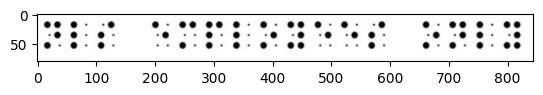

In [23]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
image_loc = "/content/sentence.png"
braille_image = cv2.imread(image_loc, cv2.IMREAD_GRAYSCALE)
plt.imshow(braille_image, cmap="gray")

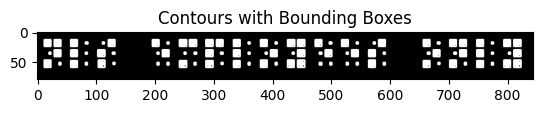

[(12, 48, 11, 12), (12, 14, 11, 11), (20, 35, 3, 3), (29, 31, 11, 11), (29, 14, 11, 11), (37, 52, 3, 4), (57, 49, 11, 11), (57, 31, 11, 11), (57, 14, 11, 11), (82, 52, 3, 4), (82, 35, 3, 3), (82, 18, 4, 3), (103, 31, 12, 11), (104, 48, 11, 12), (111, 18, 3, 3), (121, 14, 11, 11), (128, 35, 4, 3), (129, 52, 3, 3), (196, 14, 11, 11), (204, 52, 3, 4), (204, 35, 3, 3), (213, 31, 11, 11), (221, 52, 3, 4), (221, 18, 3, 3), (242, 49, 12, 11), (242, 14, 12, 11), (250, 35, 3, 3), (259, 14, 12, 11), (267, 52, 3, 4), (267, 35, 4, 3), (287, 49, 12, 11), (287, 31, 12, 11), (287, 14, 12, 11), (305, 14, 11, 11), (312, 35, 4, 3), (313, 52, 3, 3), (334, 49, 11, 11), (334, 31, 11, 11), (334, 14, 11, 11), (359, 52, 3, 4), (359, 35, 3, 3), (359, 18, 3, 3), (380, 48, 11, 12), (380, 14, 11, 11), (388, 35, 3, 3), (397, 31, 11, 11), (405, 52, 3, 4), (405, 18, 3, 3), (426, 48, 11, 12), (426, 14, 12, 11), (434, 35, 3, 3), (443, 48, 12, 12), (443, 31, 12, 11), (443, 14, 12, 11), (473, 14, 11, 11), (480, 52, 4, 4

In [24]:
_, binary_image = cv2.threshold(braille_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for i, contour in enumerate(contours):
    x, y, width, height = cv2.boundingRect(contour)

    cv2.rectangle(binary_image, (x, y), (x + width, y + height), (255, 0, 0), 2)

plt.imshow(binary_image, cmap="gray")
plt.title("Contours with Bounding Boxes")
plt.show()

bounding_boxes = [cv2.boundingRect(c) for c in contours]
bounding_boxes = sorted(bounding_boxes, key=lambda x: x[0])

print(bounding_boxes)

distances = []
for i in range(1, len(bounding_boxes)):
    distances.append(bounding_boxes[i][0] - (bounding_boxes[i-1][0] + bounding_boxes[i-1][2]))

print(distances)

distances = [d for d in distances if d > 5 and d < 25]

print(distances)

if len(distances) > 0:
    avg_distance = np.mean(distances)
else:
    avg_distance = 30

padding = int(avg_distance / 3)
print(f"Average Character Distance: {avg_distance}")
print(f"Padding to Apply: {padding}")

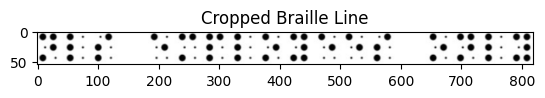

True

In [25]:
x_min = min([box[0] for box in bounding_boxes]) - padding
x_max = max([box[0] + box[2] for box in bounding_boxes]) + padding
y_min = min([box[1] for box in bounding_boxes]) - padding
y_max = max([box[1] + box[3] for box in bounding_boxes]) + padding

x_min = max(0, x_min)
x_max = min(braille_image.shape[1], x_max)
y_min = max(0, y_min)
y_max = min(braille_image.shape[0], y_max)

cropped_line = braille_image[y_min:y_max, x_min:x_max]

plt.imshow(cropped_line, cmap="gray")
plt.title("Cropped Braille Line")
plt.show()

cv2.imwrite("/content/cropped_line.png", cropped_line)

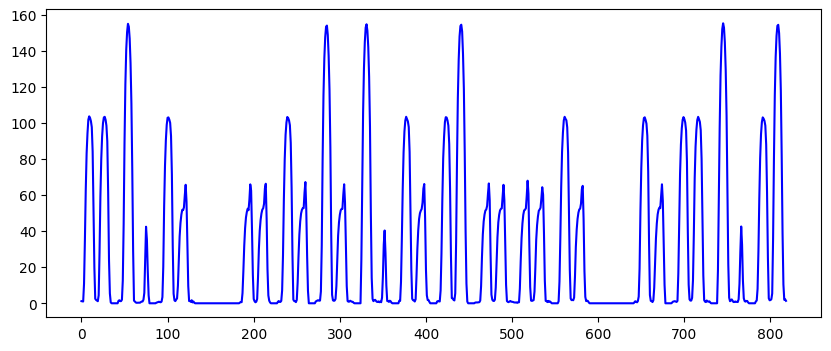

In [26]:
hist = np.mean(cropped_line ,  axis=0)
inverted_hist = np.max(hist) - hist
plt.figure(figsize=(10, 4))
plt.plot(inverted_hist, color='blue', label='Horizontal Projection')
plt.show()

Detected spaces (start, end): [(132, 184), (590, 642)]


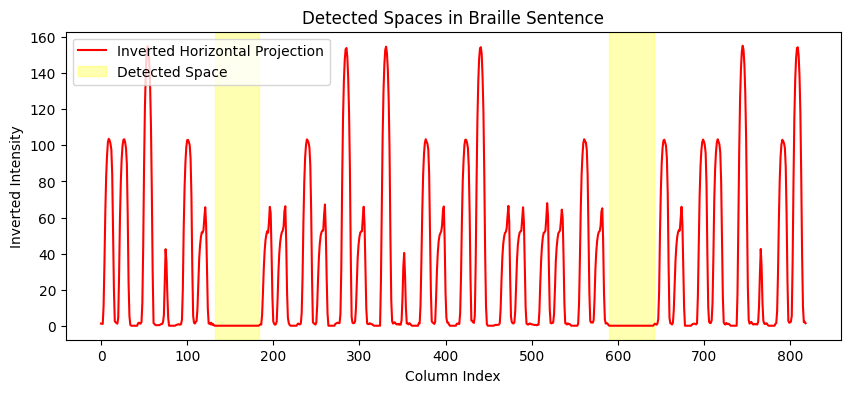

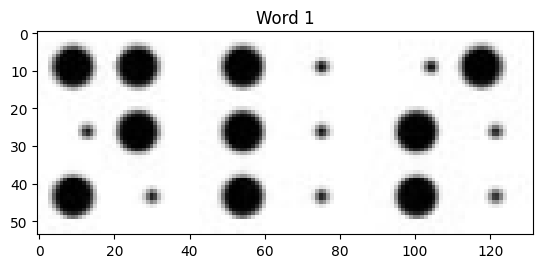

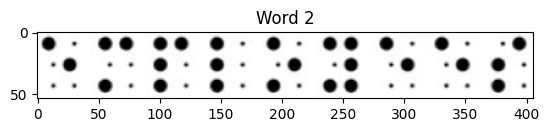

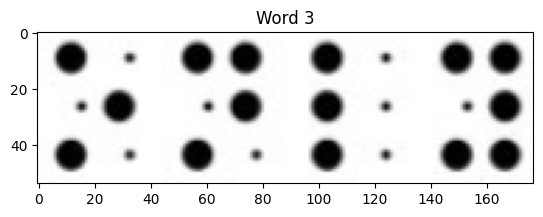

Total words extracted: 3


In [28]:
space_threshold = 40

spaces = []
i = 0

while i < len(inverted_hist):
    intensity = inverted_hist[i]

    if intensity == 0:
        start_space = i
        while i < len(inverted_hist) and inverted_hist[i] == 0:
            i += 1
        end_space = i

        if end_space - start_space > space_threshold:
            spaces.append((start_space, end_space))
    else:
        i += 1

print("Detected spaces (start, end):", spaces)

plt.figure(figsize=(10, 4))
plt.plot(inverted_hist, color='red', label='Inverted Horizontal Projection')
for (start, end) in spaces:
    plt.axvspan(start, end, color='yellow', alpha=0.3, label='Detected Space' if start == spaces[0][0] else "")
plt.title("Detected Spaces in Braille Sentence")
plt.xlabel("Column Index")
plt.ylabel("Inverted Intensity")
plt.legend()
plt.show()

words = []
start_idx = 0

for (space_start, space_end) in spaces:
    word_crop = cropped_line[:, start_idx:space_start]
    if word_crop.shape[1] > 0:
        words.append(word_crop)
    start_idx = space_end

if start_idx < cropped_line.shape[1]:
    last_word_crop = cropped_line[:, start_idx:]
    if last_word_crop.shape[1] > 0:
        words.append(last_word_crop)

for idx, word in enumerate(words):
    plt.imshow(word, cmap="gray")
    plt.title(f"Word {idx + 1}")
    plt.show()

    cv2.imwrite(f"/content/word_{idx + 1}.png", word)

print(f"Total words extracted: {len(words)}")


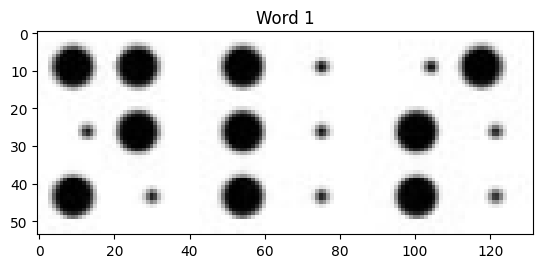

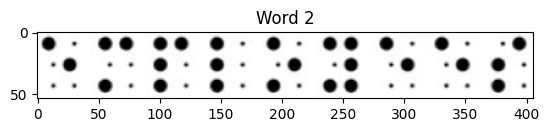

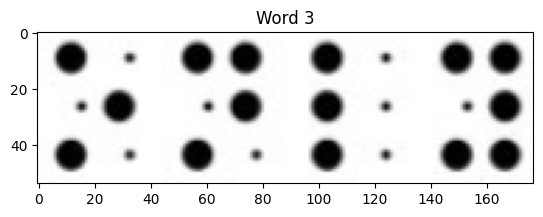

Total words extracted: 3


In [29]:
words = []
start_idx = 0

for (space_start, space_end) in spaces:
    word_crop = cropped_line[:, start_idx:space_start]
    if word_crop.shape[1] > 0:
        words.append(word_crop)
    start_idx = space_end

if start_idx < cropped_line.shape[1]:
    last_word_crop = cropped_line[:, start_idx:]
    if last_word_crop.shape[1] > 0:
        words.append(last_word_crop)

for idx, word in enumerate(words):
    plt.imshow(word, cmap="gray")
    plt.title(f"Word {idx + 1}")
    plt.show()
    cv2.imwrite(f"/content/word_{idx + 1}.png", word)

print(f"Total words extracted: {len(words)}")


Height of Image : 54
Compute Width using RCSA : 41
Total Width: 132
Number of Braille Characters : 3
0
41


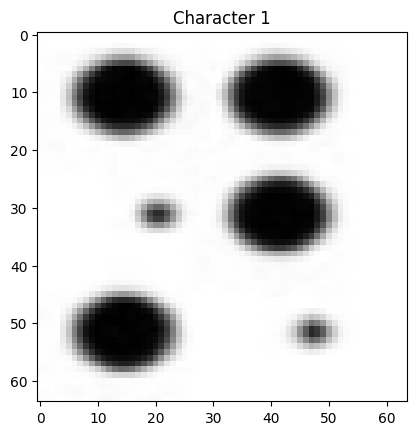

45
86


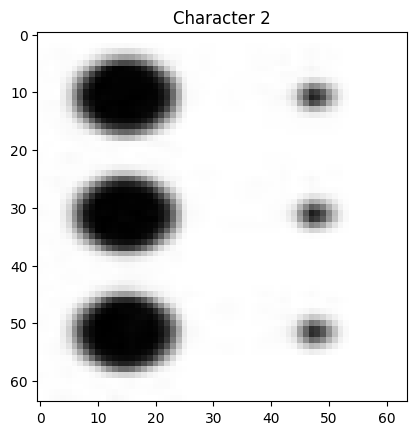

90
131


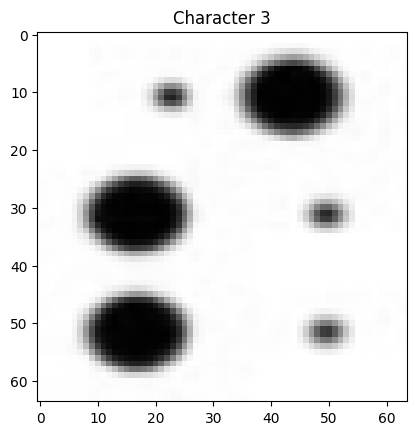

Height of Image : 54
Compute Width using RCSA : 41
Total Width: 406
Number of Braille Characters : 9
0
41


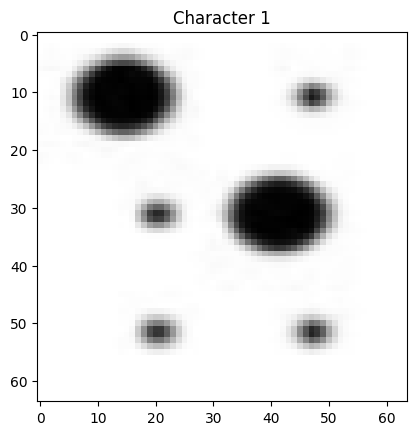

45
86


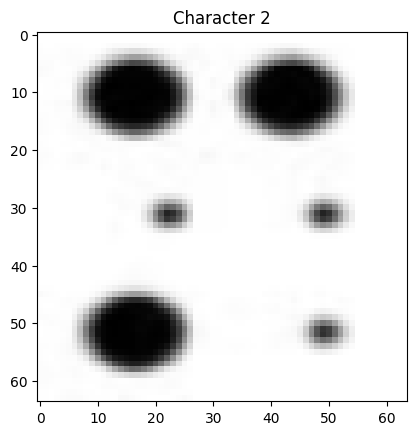

90
131


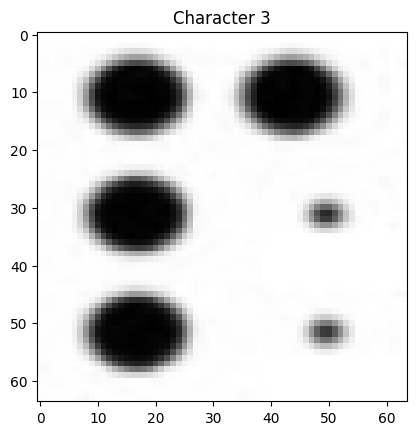

135
176


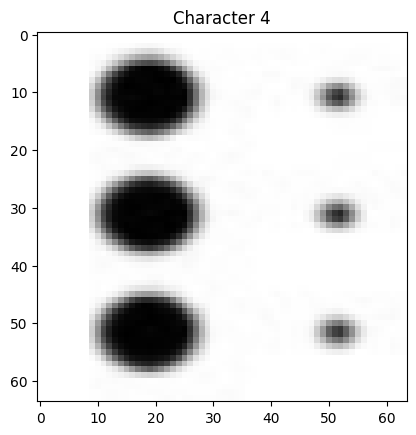

180
221


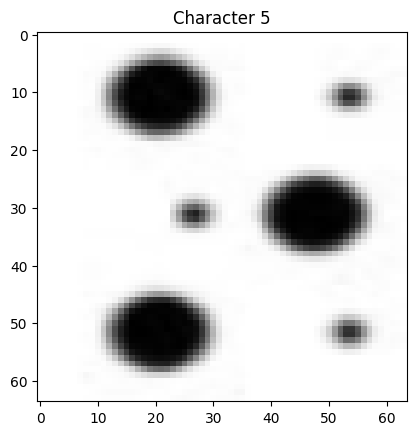

225
266


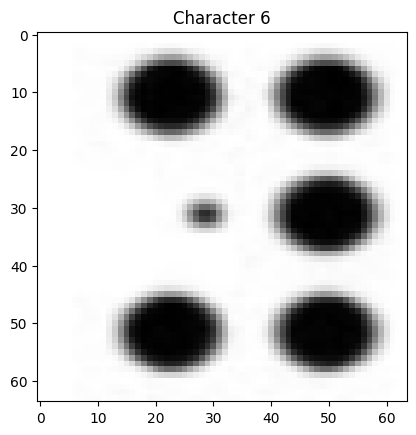

270
311


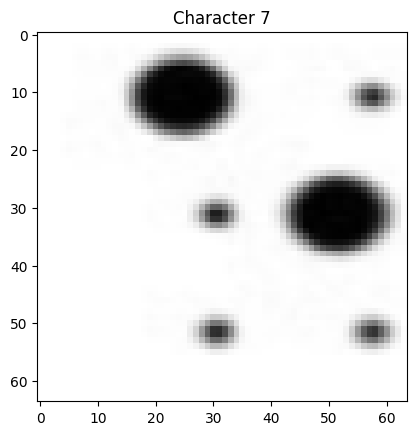

315
356


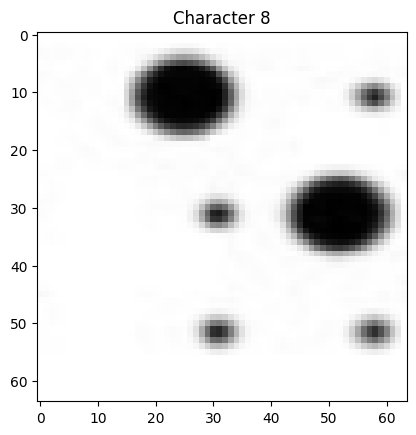

360
401


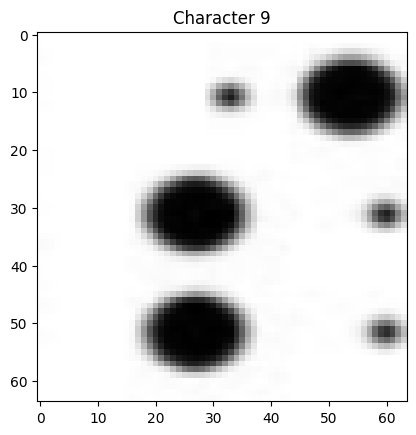

Height of Image : 54
Compute Width using RCSA : 41
Total Width: 177
Number of Braille Characters : 4
0
41


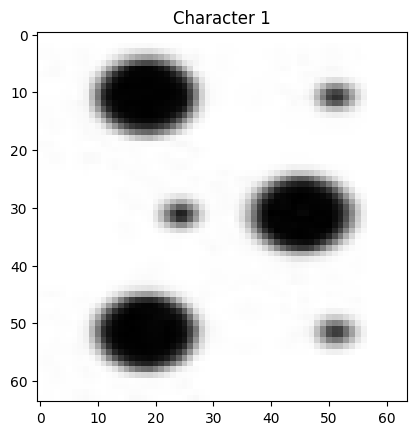

45
86


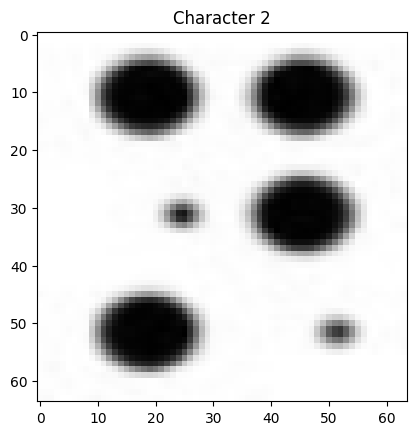

90
131


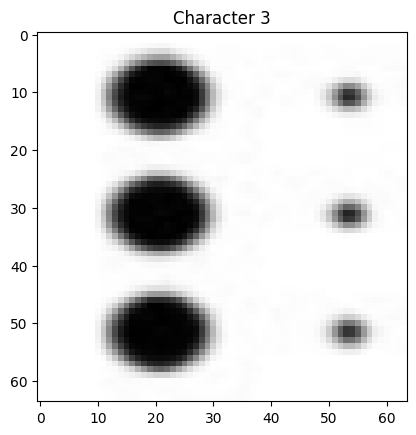

135
176


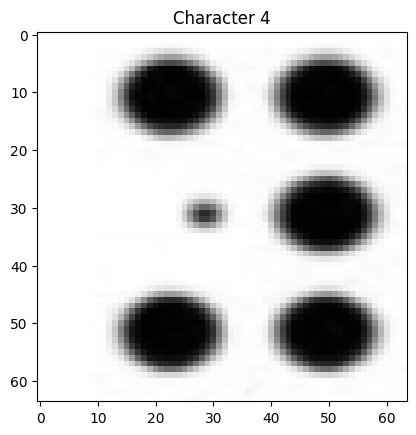

In [39]:
segmented_words = []
for word in words:
  h = word.shape[0]
  print(f"Height of Image : {h}")
  w = int(0.76*h)
  print(f"Compute Width using RCSA : {w}")
  w_total = word.shape[1]
  print(f"Total Width: {w_total}")
  n_chars = int(w_total / w)
  print(f"Number of Braille Characters : {n_chars}")
  segmented_characters = []
  past_end_x = 0
  for i in range(n_chars):
      if(i == 0):
        start_x = i * w
        print(start_x)
      else :
        start_x = int(past_end_x + avg_distance/2.5)
        print(start_x)
      end_x = start_x + w
      print(end_x)
      past_end_x = end_x
      char_segment = word[:, start_x:end_x]
      char_segment_resized = cv2.resize(char_segment, (64,64))
      segmented_characters.append(char_segment_resized)

      plt.imshow(char_segment_resized, cmap="gray")
      plt.title(f"Character {i+1}")
      plt.show()
  segmented_words.append(segmented_characters)


In [14]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

K.clear_session()

model_ckpt = ModelCheckpoint('BrailleNet.weights.h5', save_best_only=True, save_weights_only=True)
reduce_lr = ReduceLROnPlateau(patience=20,verbose=0)
early_stop = EarlyStopping(patience=30,verbose=1)

entry = L.Input(shape=(64,64,3))
x = L.SeparableConv2D(64,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(128,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(256,(2,2),activation='relu')(x)
x = L.GlobalMaxPooling2D()(x)
x = L.Dense(1024)(x)
x = L.LeakyReLU()(x)
x = L.Dense(256,kernel_regularizer=l2(2e-4))(x)
x = L.LeakyReLU()(x)
x = L.Dense(26,activation='softmax')(x)

model = Model(entry,x)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_generator,
                              validation_data=val_generator,
                              epochs=100,
                              callbacks=[model_ckpt,reduce_lr,early_stop],
                              verbose=1)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


379/379 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.2355 - loss: 2.6943 - val_accuracy: 0.7407 - val_loss: 0.9036 - learning_rate: 0.0010
Epoch 2/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7913 - loss: 0.7449 - val_accuracy: 0.9068 - val_loss: 0.3779 - learning_rate: 0.0010
Epoch 3/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9282 - loss: 0.3076 - val_accuracy: 0.9304 - val_loss: 0.2879 - learning_rate: 0.0010
Epoch 4/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9617 - loss: 0.1993 - val_accuracy: 0.9231 - val_loss: 0.2922 - learning_rate: 0.0010
Epoch 5/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9745 - loss: 0.1561 - val_accuracy: 0.9678 - val_loss: 0.1602 - learning_rate: 0.0010
Epoch 6/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9665 - loss: 0.1688 - val_accuracy: 0.9847 - val_loss: 0.1046 - learning_rate: 0.0010
Epoch 7/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9898 - loss: 0.092

In [40]:
print(len(segmented_words))

3


In [43]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
K.clear_session()

entry = L.Input(shape=(64,64,3))
x = L.SeparableConv2D(64,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(128,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(256,(2,2),activation='relu')(x)
x = L.GlobalMaxPooling2D()(x)
x = L.Dense(256)(x)
x = L.LeakyReLU()(x)
x = L.Dense(64,kernel_regularizer=l2(2e-4))(x)
x = L.LeakyReLU()(x)
x = L.Dense(26,activation='softmax')(x)

model = Model(entry, x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Load weights
model.load_weights('./BrailleNet.weights.h5')
for word in segmented_words:
  for char in word:
    char = cv2.resize(char, (64,64))
    img_array = image.img_to_array(char)  # Assuming `char` is the image
    if img_array.shape[-1] == 1:  # Check if the image is grayscale
        img_array = np.concatenate([img_array] * 3, axis=-1)  # Convert to RGB (3 channels)

    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=-1)
    letter = chr(predicted_class[0] + ord('a'))
    print(letter)
    # print(f"{predicted_class[0]}")
  print(" ")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
g
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
g
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
g
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
g
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
g
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
g
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
g
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
g
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
g
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
g
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
g
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
g
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
g
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
g
 


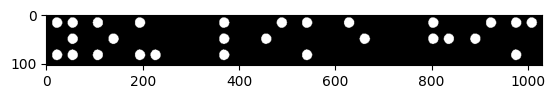

In [17]:
blurred = cv2.GaussianBlur(image,(5,5),0)
edged = cv2.Canny(blurred,50,200,255)
thresh_inv = cv2.threshold(image,0,255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
plt.imshow(thresh_inv,cmap="gray")


In [96]:
img_loc = "/content/cropped_line2.png"
cropped_line2 = cv2.imread(img_loc, cv2.IMREAD_GRAYSCALE)
h = cropped_line2.shape[0]
print(f"Height of Image : {h}")
w = int(0.74*h)
print(f"Compute Width using RCSA : {w}")
w_total = cropped_line2.shape[1]
print(f"Total Width: {w_total}")
n_chars = int(w_total / w)
print(f"Number of Braille Characters : {n_chars}")

Height of Image : 98
Compute Width using RCSA : 72
Total Width: 1130
Number of Braille Characters : 15


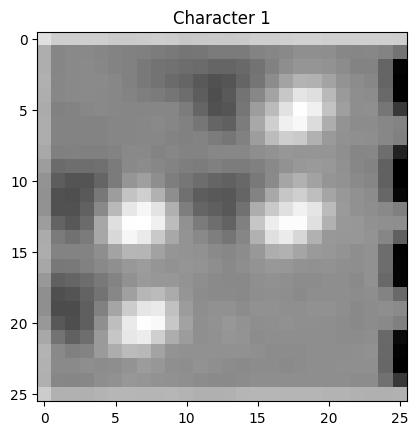

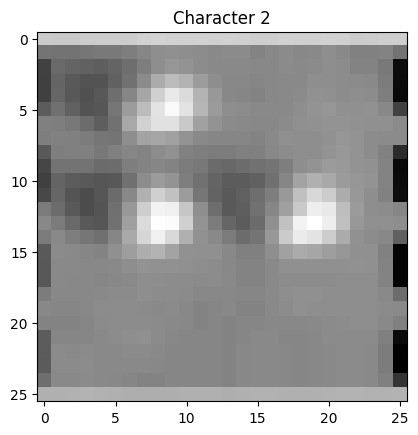

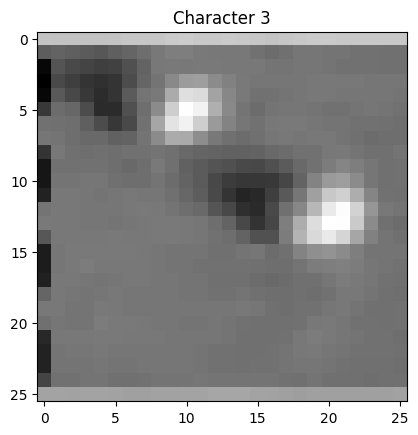

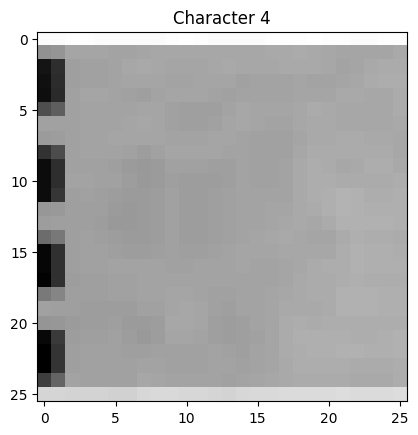

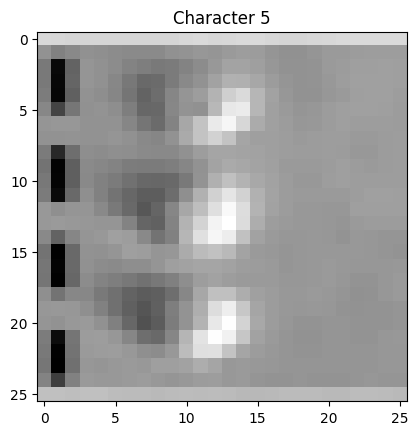

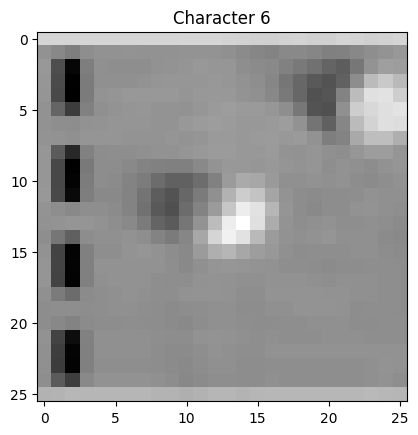

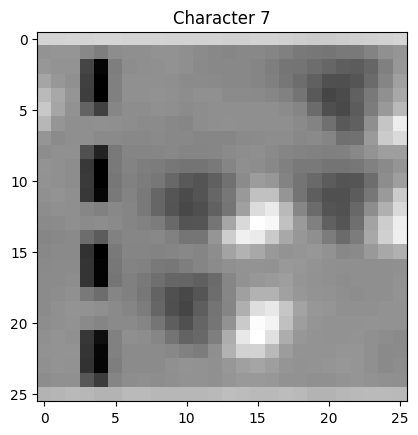

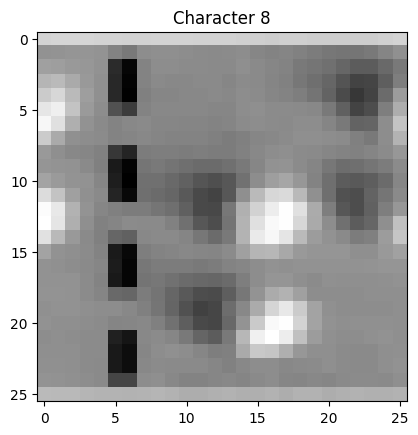

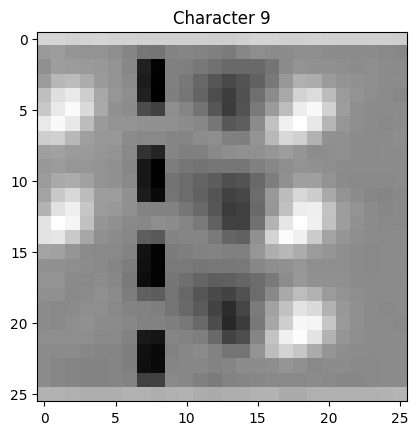

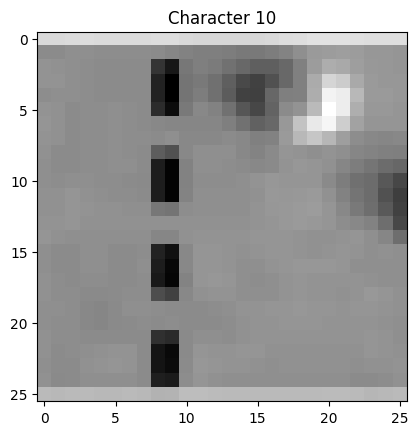

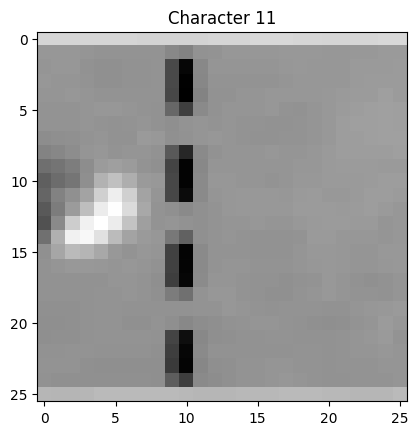

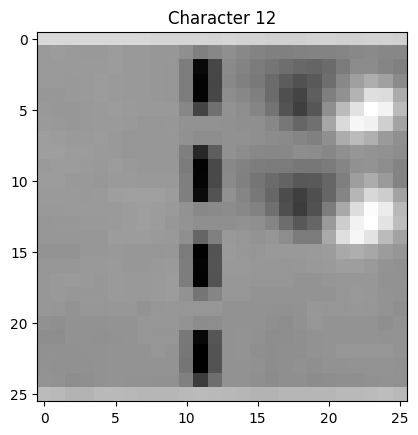

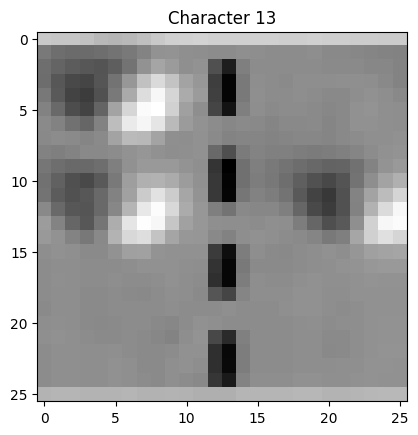

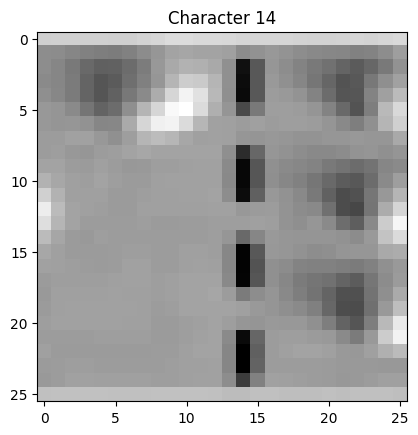

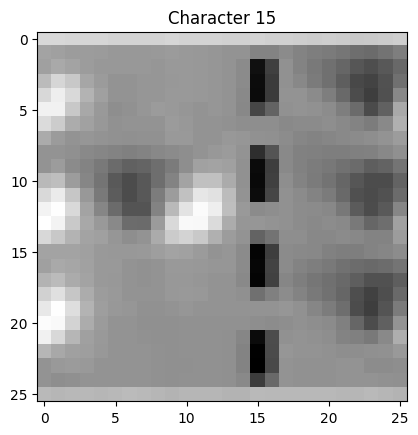

In [98]:
segmented_characters = []
past_end_x = 0
for i in range(n_chars):
    if(i == 0):
      start_x = i * w
    else :
      start_x = past_end_x
    end_x = start_x + w
    past_end_x = end_x
    char_segment = cropped_line2[:, start_x:end_x]
    char_segment_resized = cv2.resize(char_segment, (26, 26))
    segmented_characters.append(char_segment)

    plt.imshow(char_segment_resized, cmap="gray")
    plt.title(f"Character {i+1}")
    plt.show()

In [14]:
!pip install imutils

In [15]:
import imutils
ctrs = cv2.findContours(thresh_inv.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
ctrs = imutils.grab_contours(ctrs)

bounding_boxes = []
for c in ctrs:
    x, y, w, h = cv2.boundingRect(c)
    if w > 5 and h > 5:
        bounding_boxes.append((x, y, w, h))

bounding_boxes = sorted(bounding_boxes, key=lambda b: b[0])

for i, (x, y, w, h) in enumerate(bounding_boxes):
    char_image = image[y:y+h, x:x+w]
    char_image_resized = cv2.resize(char_image, (26, 26))
    plt.imsave(f'test_letter_{i}.png', char_image_resized, cmap="gray")

In [ ]:
!pip install histograms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for histograms: filename=histograms-1.0.0-py3-none-any.whl size=7064 sha256=4776632dbe65991d472b3ed1f3afd3a05d1ec2088e14a1167c345e59f3b2f97e
  Stored in directory: /root/.cache/pip/wheels/2b/eb/ee/b928c88a562c8c7bcf450937e27a999580bd1772ab4c9d4568
Successfully built histograms


/usr/local/lib/python3.10/dist-packages/histograms/utils.py:6: FutureWarning: pandas.core.index is deprecated and will be removed in a future version. The public classes are available in the top-level namespace.
  from pandas.core.index import MultiIndex


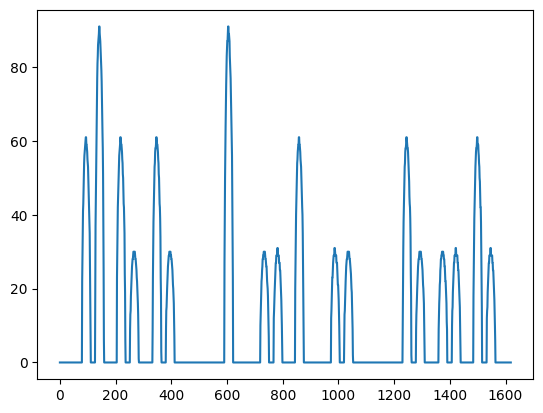

In [ ]:
from histograms import histograms
hist = cv2.reduce(thresh_inv.T,1,cv2.REDUCE_AVG).reshape(-1)
plt.plot(hist)

(array([1620.,  540.,  474.,  335.,  204.,  166.,  121.,   43.,   35.,
          24.]),
 array([ 0. ,  9.1, 18.2, 27.3, 36.4, 45.5, 54.6, 63.7, 72.8, 81.9, 91. ]),
 <BarContainer object of 10 artists>)

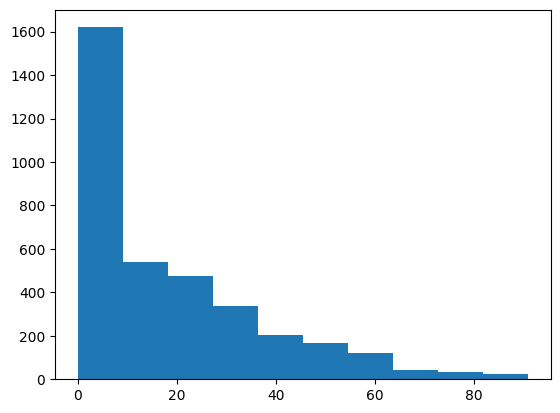

In [ ]:
histo = plt.hist(hist,cumulative=-1)
histo

In [ ]:
hist

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [ ]:
oldsize = hist.size
oldsize

1620

In [ ]:
extractedidx = np.empty(0)
extractedidx

array([], dtype=float64)

In [ ]:
for i in range(0,oldsize):
  if(hist[i]>20): # threshold value
    extractedidx = np.append(extractedidx , i)

In [ ]:
extractedidx

array([  80.,   81.,   82.,   83.,   84.,   85.,   86.,   87.,   88.,
         89.,   90.,   91.,   92.,   93.,   94.,   95.,   96.,   97.,
         98.,   99.,  100.,  101.,  102.,  103.,  104.,  105.,  106.,
        107.,  108.,  128.,  129.,  130.,  131.,  132.,  133.,  134.,
        135.,  136.,  137.,  138.,  139.,  140.,  141.,  142.,  143.,
        144.,  145.,  146.,  147.,  148.,  149.,  150.,  151.,  152.,
        153.,  154.,  155.,  156.,  157.,  205.,  206.,  207.,  208.,
        209.,  210.,  211.,  212.,  213.,  214.,  215.,  216.,  217.,
        218.,  219.,  220.,  221.,  222.,  223.,  224.,  225.,  226.,
        227.,  228.,  229.,  230.,  231.,  232.,  233.,  257.,  258.,
        259.,  260.,  261.,  262.,  263.,  264.,  265.,  266.,  267.,
        268.,  269.,  270.,  271.,  272.,  273.,  274.,  275.,  276.,
        277.,  334.,  335.,  336.,  337.,  338.,  339.,  340.,  341.,
        342.,  343.,  344.,  345.,  346.,  347.,  348.,  349.,  350.,
        351.,  352.,

In [ ]:
extractedwords = np.empty(0)
for i in range(0,extractedidx.size):
  if(extractedidx[i+1]-extractedidx[i]<35):
    pass
  else :
    extractedwords = np.append(extractedwords,extractedidx[i])

IndexError: ignored

In [ ]:
extractedwords = np.append(extractedwords , extractedidx[extractedidx.size])

In [ ]:
extractedwords1 = np.empty(0)
extractedwords1 = np.append(extractedwords1 , extractedidx[0])
for i in range(0,extractedidx.size):
  if(extractedidx[i+1]-extractedidx[i]<35):
    pass
  else:
    extractedwords1 = np.append(extractedwords1,extractedidx[i+1])

IndexError: ignored

In [ ]:
extractedwords1

array([  80.,  205.,  334.,  591.,  724.,  846.,  978., 1232., 1364.,
       1486.])

In [ ]:
extractedwords

array([ 157.,  277.,  406.,  621.,  793.,  873., 1046., 1304., 1433.,
       1558.])

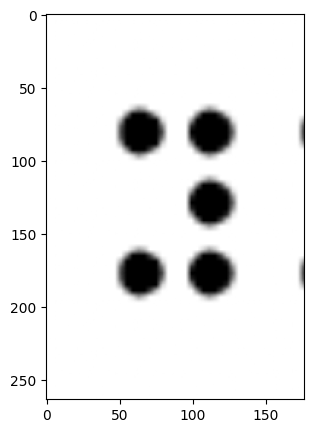

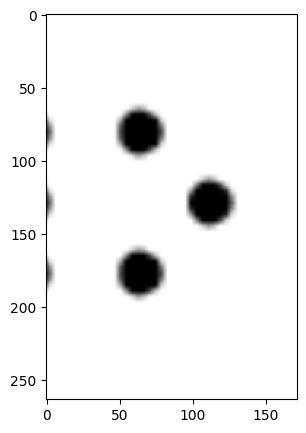

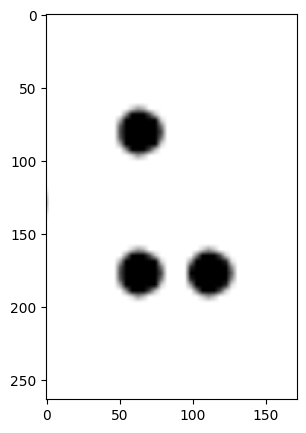

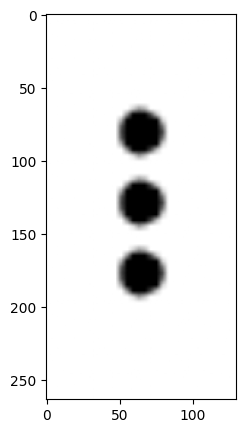

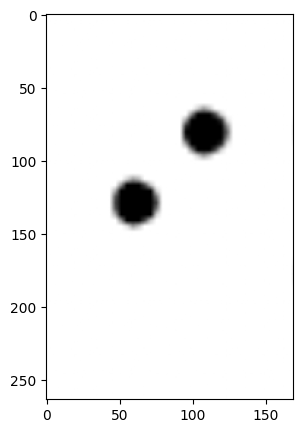

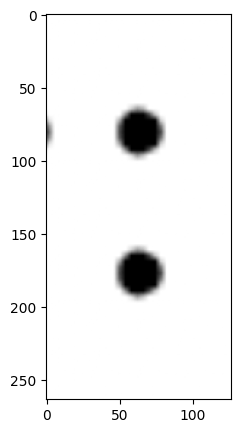

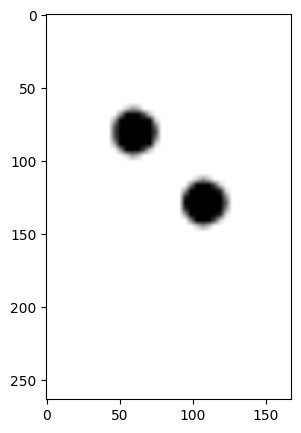

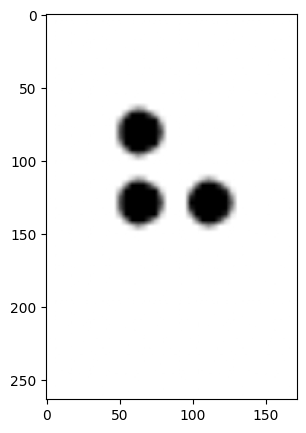

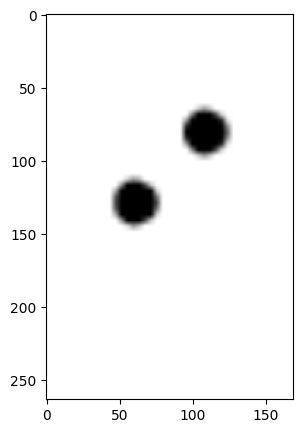

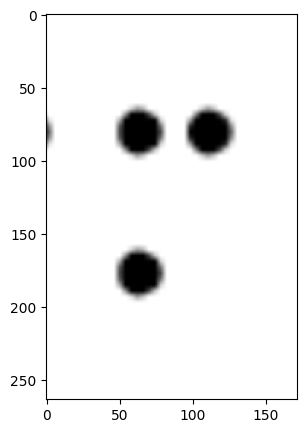

In [ ]:
for i in range(0,extractedwords.size) :
  plt.figure(figsize=(10,5))
  plt.imshow(image[:,int(extractedwords1[i]-50):int(extractedwords[i]+50)],cmap="gray")
  plt.savefig('test_letter' + str(i))



In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
img = image.load_img("/content/test_letter_enh3.png")
x = img_to_array(img)
resized = cv2.resize(x, (26, 26))
resized=np.expand_dims(resized,axis=0)
model.predict(resized)
a=np.argmax(model.predict(resized), axis=1)
letter = chr(a[0] + ord('a'))
print(letter)

1/1 [==============================] - 0s 26ms/step


array([12])